## Imports

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# import and read csv
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import string
import re

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Perform exploratory data analysis

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


link = "https://drive.google.com/file/d/18ZGW-c3oDNIEmBFUfzXl2v0v04mkSlJc/view"
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('arxiv.csv')  
  
arxiv_data = pd.read_csv('arxiv.csv')
arxiv_data.head()

,titles,summaries,terms
0,Revealing the Field Sub-subgiant Population Using a Catalog of Active Giant Stars and Gaia EDR3,"Sub-subgiant stars (SSGs) fall below the subgiant branch and/or red of the\ngiant branch in open and globular clusters, an area of the color-magnitude\ndiagram (CMD) not populated by standard stellar evolution tracks. One\nhypothesis is that SSGs result from rapid rotation in subgiants or giants...","['astro-ph.SR', 'astro-ph.GA']"
1,ALMA detection of ethyl cyanide and methyl formate in the hot molecular core IRAS 18566+0408,"In millimeter/submillimeter wavelength, the studies of the complex molecular\nemission lines towards the hot molecular cores demonstrate valuable details\nabout the chemical composition and massive star formation processes. We present\nthe interferometric detection of rotational molecular emissi...",['astro-ph.GA']
2,Accretion processes in the galaxy cluster Hydra A/Abell 780,"Clusters of galaxies evolve and accrete mass, mostly from small galaxy\nsystems. Our aim is to study the velocity field of the galaxy cluster Abell\n780, which is known for the powerful radio source Hydra A at its center and\nwhere a spectacular X-ray tail associated with the galaxy LEDA 87445 h...","['astro-ph.CO', 'astro-ph.GA']"
3,Radio astronomy locates the neutrino origin in bright blazars,"High-energy astrophysical neutrinos have been observed by several telescopes\nin the last decade, but their sources still remained unknown. We address the\nproblem of locating astrophysical neutrinos' sources in a statistical manner.\nWe show that blazars positionally associated with IceCube neu...","['astro-ph.HE', 'astro-ph.GA']"
4,The extragalactic $γ$-ray background: imprints from the physical properties and evolution of star-forming galaxy populations,"Star-forming galaxies (SFGs) are expected to harbour an abundant reservoir of\ncosmic rays (CRs). At GeV energies, these CRs can undergo hadronic interactions\nwith interstellar gases to produce $\gamma$-rays, and the unresolved\n$\gamma$-ray emission from populations of SFGs form a component of...","['astro-ph.GA', 'astro-ph.HE']"


In [ ]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 89336 rows in the dataset.


In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 19134 duplicate titles.


In [ ]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 70202 rows in the deduplicated dataset.
22
152


In [ ]:
arxiv_data_filtered = arxiv_data

## Convert the string labels to lists of strings

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['astro-ph.SR', 'astro-ph.GA']), list(['astro-ph.GA']),
       list(['astro-ph.CO', 'astro-ph.GA']),
       list(['astro-ph.HE', 'astro-ph.GA']),
       list(['astro-ph.GA', 'astro-ph.HE'])], dtype=object)

In [ ]:
dict_len = {}
for i in range(arxiv_data_filtered.shape[0]):
    if(len(arxiv_data_filtered.iloc[i]["terms"]) not in dict_len):
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] = 1
    else:
        dict_len[len(arxiv_data_filtered.iloc[i]["terms"])] += 1
print("Occurancy of number of labels in a term: ")
dict_len = dict(sorted(dict_len.items(), key=lambda item: item[1], reverse=True))
for k, v in dict_len.items():
    print(f" - The number of paper have {k} labels in it's term: {v}")

Occurancy of number of labels in a term: 
 - The number of paper have 1 labels in it's term: 46399
 - The number of paper have 2 labels in it's term: 20635
 - The number of paper have 3 labels in it's term: 2904
 - The number of paper have 4 labels in it's term: 209
 - The number of paper have 5 labels in it's term: 54
 - The number of paper have 6 labels in it's term: 1


##Pre-processing dataset


In [ ]:
all_terms = sum(arxiv_data_filtered["terms"],[])
all_terms = nltk.FreqDist(all_terms) 
# create dataframe
all_terms_df = pd.DataFrame({'Term': list(all_terms.keys()), 
                              'Count': list(all_terms.values())})

In [ ]:
def clean_text(text):
  # remove new line characters
  text = re.sub(r"\n", " ", text)
  # remove email
  text = re.sub(r"([A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.?[A-Za-z0-9-.]+)", "", text)
  # remove url
  text = re.sub(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*", "", text)
  # remove punctuation
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
  # remove words including numbers
  text = re.sub(r"\w*\d\w*", "", text)
  # remove single character and duplicated words
  text = ' '.join(word for word in list(set(text.split())) if len(word) > 1)
  # replace multiple whitespace by one whitespace
  text = re.sub(r"\s+", " ", text)
  # lower all text
  text = text.lower()
  # strip all text
  text = text.strip()
  return text

In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  cleaned_text = []
  # turn text to a list of words
  word_list = text.split()
  for word in word_list:
    if word not in stop_words:
      cleaned_text.append(word)
  return ' '.join(cleaned_text)

In [ ]:
def lemmatize_text(text):
  wnl = WordNetLemmatizer()
  pos_text = pos_tag(word_tokenize(text))
  cleaned_text = []
  for word, tag in pos_text:
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lem_word = word
    else:
      lem_word = wnl.lemmatize(word, wntag)
    cleaned_text.append(lem_word)
  return ' '.join(cleaned_text)

In [ ]:
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(clean_text)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(remove_stopwords)
arxiv_data_filtered['summaries'] = arxiv_data_filtered['summaries'].apply(lemmatize_text)
arxiv_data_filtered['summaries']

0        normal present binary ssgs know convection lower standard stellar find dense rich subgiant candidate produce tess astrometry sub track day starspots system due metal fall tidal hypothesis study field magnitude dramatic period suggest branch candidate giant rapid cvns star rotation position rare ...
1        complex present original pm core line millimeter mcmc relative valuable spectral respectively hcc estimate hc molecule ghz wavelength transition core total line atacama except cm formation cn three specie demonstrate abundance unblended hot towards alma apply cyanide ch determine molecular carlo...
2        space substructure small line know distance substructure relative region construct leda collision technique rest cluster center although km telescopio relate first system dynamically core asymmetry galaxy cluster analyze mpc abell tail obtain study member sigmav smaller higher impact field spect...
3        correspond produce astrophysical region coincide telescope core 

## Split training set, validation set and test set

In [ ]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    # stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 49141
Number of rows in validation set: 10530
Number of rows in test set: 10531


## Multi-label binarization

In [ ]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'astro-ph.GA', 'astro-ph.SR', 'astro-ph.EP', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.CO']


In [ ]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['astro-ph.EP']
Label-binarized representation: [[0. 0. 0. 1. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects


In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE


def unify_text_length(text, label):
    return tf.expand_dims(text, -1), label


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(unify_text_length, num_parallel_calls=auto).cache()
    return dataset.batch(batch_size)


In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'normal superimpose correspond wavelet advance inside sectoral relative stellar occultation planetary place respectively however visual precise reveal six oscillation weaker ring sufficiently provide observed combining constraint sequence planet frequency spectrometer infrared fundamental demonstrate unambiguously generate spacecraft tool signal map arm consist ring azimuthal fortunately determine rotation amplitude day able one spiral actually resonances study structure multiple uncovered number rate another around interior pattern allow furthermore wave four mode new obvious broad analytical analysis mode search wavenumbers vims single generate clarify many previously pattern degree recent reveal large excite identified wavelet wave onboard imply data complete saturn structure help two cassini probably rotate analysis strong unknown base yielding recent'
Label(s): ['astro-ph.EP']
 
Abstract: b'eclipse present utilised binary inspection best simultaneously subsequently asse

## Vectorization

In [ ]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 179


In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


## Create a text classification model


In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model


## Train the model

Epoch 1/100
384/384 [==============================] - 11s 26ms/step - loss: 0.4881 - precision: 0.5432 - recall: 0.2681 - val_loss: 0.2899 - val_precision: 0.7160 - val_recall: 0.6203
Epoch 2/100
384/384 [==============================] - 9s 23ms/step - loss: 0.2845 - precision: 0.7513 - recall: 0.5919 - val_loss: 0.2478 - val_precision: 0.7831 - val_recall: 0.6792
Epoch 3/100
384/384 [==============================] - 9s 23ms/step - loss: 0.2544 - precision: 0.7909 - recall: 0.6472 - val_loss: 0.2435 - val_precision: 0.7968 - val_recall: 0.6695
Epoch 4/100
384/384 [==============================] - 8s 22ms/step - loss: 0.2442 - precision: 0.8021 - recall: 0.6603 - val_loss: 0.2366 - val_precision: 0.8017 - val_recall: 0.6802
Epoch 5/100
384/384 [==============================] - 10s 25ms/step - loss: 0.2376 - precision: 0.8080 - recall: 0.6662 - val_loss: 0.2326 - val_precision: 0.7989 - val_recall: 0.6901
Epoch 6/100
384/384 [==============================] - 10s 25ms/step - loss: 0

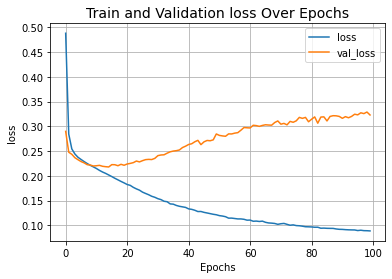

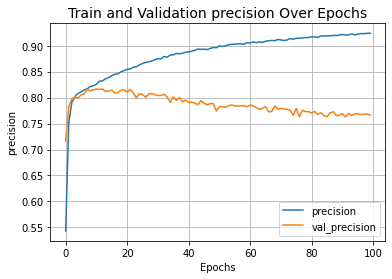

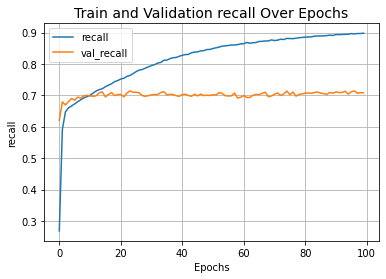

In [ ]:
epochs = 100

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs,
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("precision")
plot_result("recall")

## Evaluate the model

###Exact Match Radio

In [ ]:
def get_y_true_and_y_pred_prob_value():
    model_for_evaluate = keras.Sequential([text_vectorizer, shallow_mlp_model])
    evaluate_dataset = make_dataset(test_df, is_train=False)

    y_true = []
    y_pred_prob = []

    for text_batch, label_batch in evaluate_dataset:
        predicted_probabilities = model_for_evaluate.predict(text_batch)
        for i, text in enumerate(text_batch):
            label = label_batch[i].numpy()[None, ...]
            y_true.append(label[0])
            y_pred_prob.append(predicted_probabilities[i])
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    return y_true, y_pred_prob


In [ ]:
def get_y_pred(y_pred_prob, k=3, threshold=0.5):
    y_pred = []
    for pred in y_pred_prob:
        top_k_labels = [
            x
            for _, x in sorted(
                zip(pred, lookup.get_vocabulary()),
                key=lambda pair: pair[0],
                reverse=True,
            )
        ][:k]
        y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
        for j in range(len(vocab)):
            if(vocab[j] in top_k_labels):
                if(pred[j] > threshold):
                    y_top_k_labels[j] = 1
                else:
                    top_k_labels.remove(vocab[j])
        y_pred.append(y_top_k_labels)
    y_pred = np.array(y_pred)   
    return y_pred


In [ ]:
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
for k in range(1,7,1):
    for threshold in np.arange(0.3,0.8,0.1):
        y_pred = get_y_pred(y_pred_prob, k, threshold)
        number_of_test = test_df.shape[0]
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, y_pred)
        print(f"With k = {k} and threshold = {round(threshold,1)} - Exact Match Radio accuracy on the test set: {round(acc * 100, 2)}%")

With k = 1 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 53.89%
With k = 1 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 53.79%
With k = 1 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 53.47%
With k = 1 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 52.91%
With k = 1 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 52.32%
With k = 2 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 49.46%
With k = 2 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 51.33%
With k = 2 and threshold = 0.5 - Exact Match Radio accuracy on the test set: 52.3%
With k = 2 and threshold = 0.6 - Exact Match Radio accuracy on the test set: 52.34%
With k = 2 and threshold = 0.7 - Exact Match Radio accuracy on the test set: 52.75%
With k = 3 and threshold = 0.3 - Exact Match Radio accuracy on the test set: 48.87%
With k = 3 and threshold = 0.4 - Exact Match Radio accuracy on the test set: 

### Hamming Loss

In [ ]:
from sklearn.metrics import hamming_loss
y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)
hml = hamming_loss(y_true, y_pred)
print(f"Hamming Loss = {hml}")

Hamming Loss = 0.09950215011462757


### Confusion Matrix Metrics

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

y_true, y_pred_prob = get_y_true_and_y_pred_prob_value()
y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

m = multilabel_confusion_matrix(y_true, y_pred)

for i in range(1,len(m)):
    print("Multilabel_confusion_matrix_of: "+vocab[i])
    print(m[i])
    print()
    # print(vocab[i])

Multilabel_confusion_matrix_of: astro-ph.GA
[[6633  576]
 [ 935 2387]]

Multilabel_confusion_matrix_of: astro-ph.SR
[[6870  584]
 [1085 1992]]

Multilabel_confusion_matrix_of: astro-ph.EP
[[7593  416]
 [ 475 2047]]

Multilabel_confusion_matrix_of: astro-ph.HE
[[7902  504]
 [ 582 1543]]

Multilabel_confusion_matrix_of: astro-ph.IM
[[7949  562]
 [ 632 1388]]

Multilabel_confusion_matrix_of: astro-ph.CO
[[8568  390]
 [ 594  979]]



### Precision, Recall, F1_score, micro-average, macro-average metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = get_y_pred(y_pred_prob, k=3, threshold=0.5)

print(classification_report(y_true, y_pred,target_names=vocab, zero_division = 0))

              precision    recall  f1-score   support

       [UNK]       0.00      0.00      0.00         0
 astro-ph.GA       0.81      0.72      0.76      3322
 astro-ph.SR       0.77      0.65      0.70      3077
 astro-ph.EP       0.83      0.81      0.82      2522
 astro-ph.HE       0.75      0.73      0.74      2125
 astro-ph.IM       0.71      0.69      0.70      2020
 astro-ph.CO       0.72      0.62      0.67      1573

   micro avg       0.77      0.71      0.74     14639
   macro avg       0.66      0.60      0.63     14639
weighted avg       0.77      0.71      0.74     14639
 samples avg       0.80      0.76      0.75     14639



### Exist 1 in Top k predicts is true Accuracy

In [ ]:
def top_k_predict_is_true_accuracy(y_true, y_pred_prob, k=3, threshold = 0.5):
    score = 0
    for i in range(len(y_pred_prob)):
            top_k_labels = [
                x
                for _, x in sorted(
                    zip(y_pred_prob[i], lookup.get_vocabulary()),
                    key=lambda pair: pair[0],
                    reverse=True,
                )
            ][:k]
            y_top_k_labels = np.zeros(y_pred_prob[0].shape[0])
            for label in top_k_labels:
                if(y_true[i][vocab.index(label)] == 1):
                    score += 1
                    break
    return score/len(y_pred_prob)

acc = top_k_predict_is_true_accuracy(y_true, y_pred_prob, 3, 0.5)
print(f"Accuracy: {acc}")

Accuracy: 0.97369670496629


## Inference

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

k=6

# Perform inference.
for i, text in enumerate(text_batch[:50]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_k_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:k]
    predicted_proba.sort(reverse = True)
    for i in reversed(range(len(predicted_proba)-1)):
        if(predicted_proba[i] < 0.3 and len(top_k_labels) > 0):
            top_k_labels.pop(i)
    print(f"Predicted Label(s): ({', '.join([label for label in top_k_labels])})")
    print(" ")

Abstract: b'comet monthly present small variability pm eject speed sublimate white relative publish spectroscopy planetary transiting modulate tess km strengthen various first obtain absorption dwarf observe nightly line atmospheric unable period facility blue material disintegrating high light prominent dynamic follow shift roughly use fit ca along change discover likely find narrow structure orbit detailed effluent eff periodically new transient exhibit debris significant environmental clump dip star status orbital timescales photometry different evidence previously range reminiscent behavior ztf observatory feature hr signal harbor weekly na zwicky origin wd odot asteroid resolution two asteroid parameter detect within attribute interpret curve broadband velocity circumstellar body photometric mathrm temperature dusty otherwise identify'
Label(s): ['astro-ph.SR' 'astro-ph.EP']
Predicted Label(s): (astro-ph.EP)
 
Abstract: b'latter present characterization know stellar spectroscopy l